<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/03_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Network

1. Perceptron
2. Forward propagation - weights, activation, linear and non-linear functions
3. Loss, Cost and Loss Function
4. Backpropagation

### Regression

Loss Function - Mean Squared Error (MSE)

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

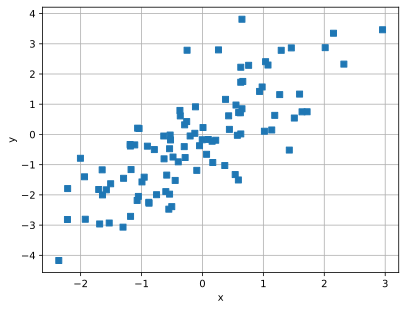

In [ ]:
# create data

N = 100
x = t.randn(N, 1)
y = x + t.randn(N, 1)

# plot the pairs
plt.plot(x, y, 's')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [ ]:
# build model

ANNreg = nn.Sequential(
    nn.Linear(1, 1, bias=True),  # input layer
    nn.ReLU(),                   # activation function
    nn.Linear(1, 1, bias=True)    # output layer
)

ANNreg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
# learning rate
learningRate = 0.01

# loss function
lossfun = nn.MSELoss()

# optimizer (the flavour of gradient descent to be implemented)
optimizer = t.optim.SGD(ANNreg.parameters(), lr=learningRate)

In [ ]:
# train the model
numepoch = 1000
losses = t.zeros(numepoch)

for epochi in range(numepoch):

  # forward pass
  y_pred = ANNreg(x)

  # compute loss
  loss = lossfun(y_pred, y)
  losses[epochi] = loss

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

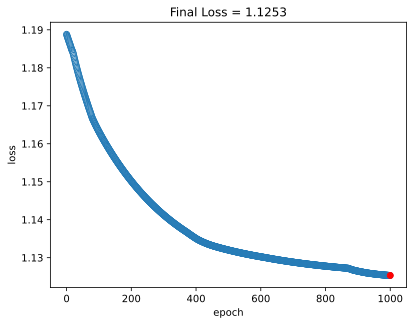

In [ ]:
# show the losses

# manually compute losses
# final forward pass
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions - y).pow(2).mean()

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.plot(numepoch, testloss.detach(), 'ro')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Final Loss = %g'%testloss.item())
plt.show()

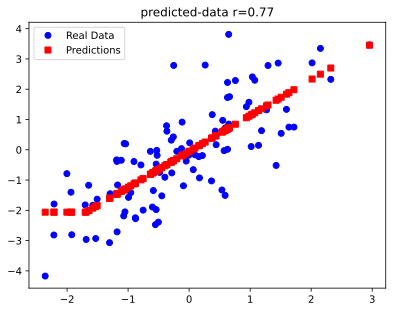

In [ ]:
# plot the data

plt.plot(x,y,'bo',label='Real Data')
plt.plot(x,predictions.detach(),'rs',label='Predictions')
plt.title(f"predicted-data r={np.corrcoef(y.T,predictions.detach().T)[0,1]:.2f}")
plt.legend()
plt.show()

### Manipulate Regression Slopes

In [ ]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [ ]:
def data(N,m):
  x = t.randn(N, 1)
  y = m*x + t.randn(N, 1) * 1.5
  return x, y

In [ ]:
def model(x,y,learning_rate,momentum,numepoch):

  # build model
  ANNreg = nn.Sequential(
      nn.Linear(1, 1, bias=True),  # input layer
      nn.ReLU(),                   # activation function
      nn.Linear(1, 1, bias=True)    # output layer
  )

  # loss function
  lossfun = nn.MSELoss()

  # learning rate and momentum
  lr = learning_rate
  mtm = momentum

  # optimizer (the flavour of gradient descent to be implemented)
  optimizer = t.optim.SGD(ANNreg.parameters(), lr=lr)

  # number of epochs
  nepoch = numepoch
  losses = t.zeros(nepoch)

  for i in range(nepoch):
    y_pred = ANNreg(x)
    loss = lossfun(y_pred, y)
    losses[i] = loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  predictions = ANNreg(x)

  return predictions, losses


In [ ]:
slopes = t.linspace(-2,2,21)
numExps = 50
results = np.zeros((len(slopes),numExps,2))

for i,m in enumerate(slopes):
  for j in range(numExps):
    x, y = data(50,slopes[i])
    yHat, losses = model(x,y,0.01,0.9,1000)

    # store the final loss and performance
    results[i,j,0] = losses[-1]
    results[i,j,1] = np.corrcoef(y.T,yHat.detach().T)[0,1]

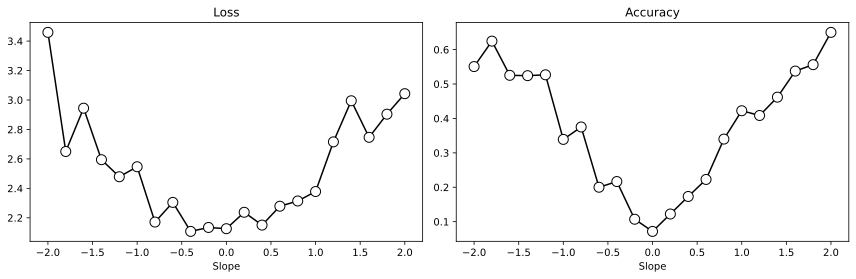

In [ ]:
# correlation can be 0 if the model didn't do well. Set nan's -> 0
results[np.isnan(results)] = 0

# plot loss and accuracy as a function of slope

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(slopes,np.mean(results[:,:,0],axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax[0].set_xlabel('Slope')
ax[0].set_title('Loss')

ax[1].plot(slopes,np.mean(results[:,:,1],axis=1), 'ko-', markerfacecolor='w', markersize=10)
ax[1].set_xlabel('Slope')
ax[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

1. Why were losses larger with larger slopes, even though the fit to the data was better?
- Losses are not normalized, they are in the scale of data. Larger slopes led to more variance in y.

- **Note :** The losses could only be compared across same data, or in different dataset that are normalized to the same numeric range.

2. Why did the model accuracy dropped to 0 when the slope was close to 0?
- x is less informative about y when the slope descreases. The model had less useful information about y.

- **Note :** ANNs (and DL in general) don't predict data values; they learn relationships across variables and provide the distribution of y for a given x from which y_pred is chosen as the one y which holds highest probability of occurence.

### Classification

In [73]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

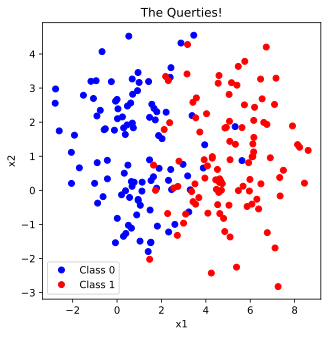

In [75]:
# catagorical dummy data

nPerClust = 100
blur = 1.5

A = [1,1]
B = [5,1]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [76]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2, 1, bias=True),  # imput layer
    nn.ReLU(),                   # activation layer
    nn.Linear(1, 1, bias=True),  # output layer
    nn.Sigmoid(),                # final activation unit
)

ANNclassify

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [77]:
# loss function
lossfun = nn.BCELoss()
# For future reference please note that it is better to use BCEWithLogitsLoss

# learning rate
lr = 0.1

# optimizer
optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lr)

In [78]:
# number of epochs
numepochs = 1000
losses = t.zeros(numepochs)

for i in range(numepochs):

  # forward pass
  y_pred = ANNclassify(data)

  # calculate loss and store value
  loss = lossfun(y_pred,labels)
  losses[i] = loss

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

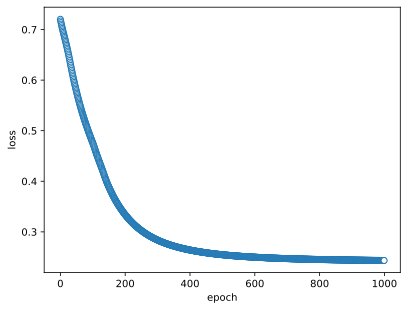

In [79]:
# show the losses

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [82]:
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions > 0.5

# find errors
misclassified = np.where(predlabels.detach().T != labels.T)[1]
# misclassified

# total accuracy
totalacc = 100 - 100*len(misclassified)/len(labels)

print(f'Total Accuracy = {totalacc}%')

Total Accuracy = 90.5%


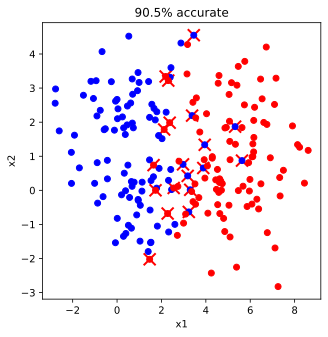

In [83]:
# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
# plt.legend()
plt.show()

### Learning Rate Comparison

In [2]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

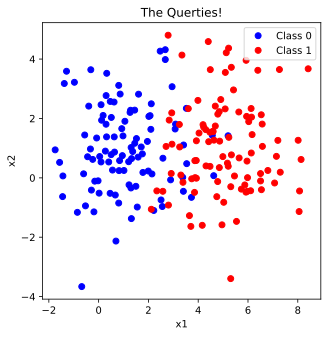

In [3]:
# catagorical dummy data

nPerClust = 100
blur = 1.5

A = [1,1]
B = [5,1]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[t.where(labels==0)[0],0], data[t.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[t.where(labels==1)[0],0], data[t.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [4]:
def BuildANNclassify(learning_rate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2, 1, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(1, 1, bias=True),  # output layer
      # nn.Sigmoid(),                # final activation unit
  )

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # learning rate (function variable here)
  lrate = learning_rate

  # optimizer
  optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lrate)

  return ANNclassify, lossfun, optimizer

In [5]:
def train_model():
  # number of epochs
  numepochs = 1000
  losses = t.zeros(numepochs)

  for i in range(numepochs):

    # forward pass
    y_pred = ANNclassify(data)

    # calculate loss and store value
    loss = lossfun(y_pred,labels)
    losses[i] = loss

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final predictions
  predictions = ANNclassify(data)

  # accuracy
  totalacc = 100*t.mean(((predictions > 0) == labels).float())
  # Shouldn't this be predictions > 0.5? Because we have omitted sigmoid layer and used BCEwithLogitsLoss

  return losses, predictions, totalacc

predictions samples: 
tensor([-3.4298, -2.9378, -5.1130, -0.6103, -4.2920, -0.9788, -2.1799, -4.9453,
        -7.8093], grad_fn=<PermuteBackward0>)
total accuracy: 89.5


/tmp/ipython-input-1007335292.py:5: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  print(f"predictions samples: \n{predictions[t.where((predictions > 0)==labels)[0],0][0:9].T}")


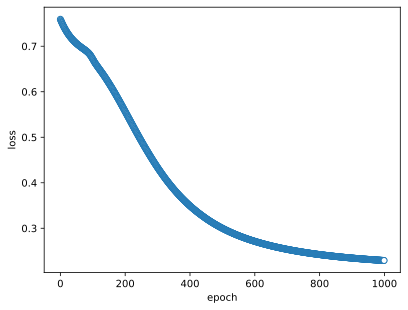

In [6]:
# let's test the code

ANNclassify, lossfun, optimizer = BuildANNclassify(0.05)
losses, predictions, totalacc = train_model()
print(f"predictions samples: \n{predictions[t.where((predictions > 0)==labels)[0],0][0:9].T}")
print(f"total accuracy: {totalacc}")

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

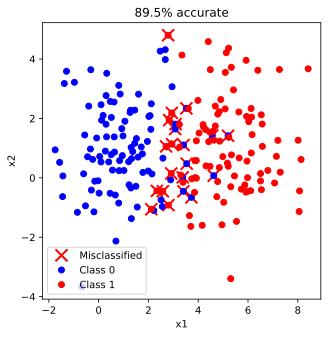

In [7]:
# view the check data

# t.where((predictions > 0).float().T != labels.T)

# find errors
misclassified = t.where(((predictions > 0)).detach().T != labels.T)[1]
# misclassified
# data[misclassified,0]

# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [9]:
# Let's run the experiment

learning_rates = t.linspace(0.001, 0.1, 50)
numepochs = 1000

accByLR = t.zeros(len(learning_rates))
allLosses = t.zeros((len(learning_rates),numepochs))

for i,lr in enumerate(learning_rates):
  ANNclassify, lossfun, optimizer = BuildANNclassify(lr)
  losses, predictions, totalacc = train_model()
  accByLR[i] = totalacc
  allLosses[i,:] = losses.detach()

In [102]:
# accByLR
# allLosses

tensor(0.8600)

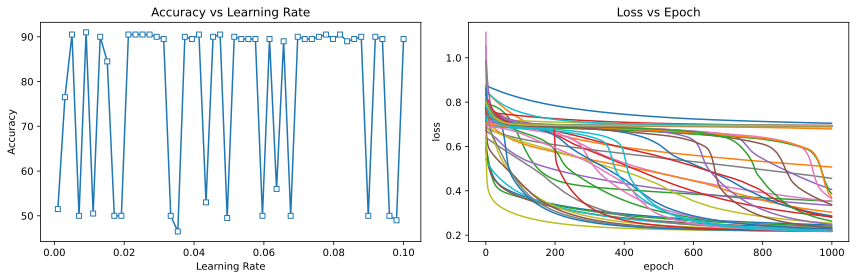

In [10]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(learning_rates,accByLR,'s-',markerfacecolor='w',markersize=5)
ax[0].set_xlabel('Learning Rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs Learning Rate')

ax[1].plot(allLosses.T)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].set_title('Loss vs Epoch')

plt.tight_layout()
plt.show()

Sometimes the model got lucky with an initial weight randomization. This means chance played a role in our conclusions.

Let's run each iteration 50 times and take average of the results.

In [11]:
# let's run each iteration of learning rate over 50 rounds and take average of accuracy

learning_rates = t.linspace(0.001, 0.1, 50)
NumExps = 50

avgAccByLR = t.zeros(len(learning_rates))
avgAllLosses = t.zeros((len(learning_rates),numepochs))

for i,lr in enumerate(learning_rates):
  AccByLR = t.zeros(NumExps)
  AllLosses = t.zeros((NumExps,numepochs))
  for j in range(NumExps):
    ANNclassify, lossfun, optimizer = BuildANNclassify(lr)
    losses, predictions, totalacc = train_model()
    AccByLR[j] = totalacc
    AllLosses[j,:] = losses.detach()

  avgAccByLR[i] += AccByLR.mean()
  avgAllLosses[i,:] += AllLosses.mean(axis=0)


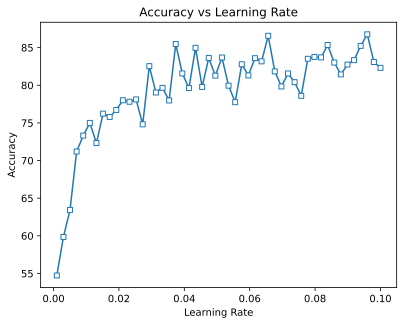

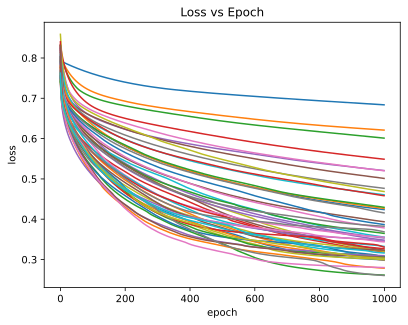

In [12]:
plt.plot(learning_rates,avgAccByLR,'s-',markerfacecolor='w',markersize=5)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

plt.plot(avgAllLosses.T)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.show()

### Multilayer ANN Primer

Let's carry out the same experiment with more layers and neuron units

In [16]:
import numpy as np
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

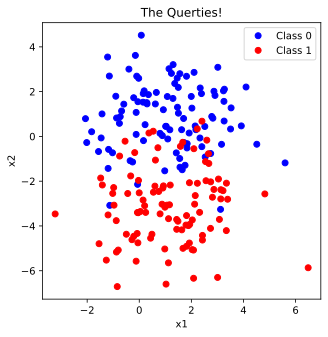

In [17]:
# catagorical dummy data

nPerClust = 100
blur = 1.5

A = [1,1]
B = [1,-3]

# generate data
a = [A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)), np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to PyTorch
data = t.tensor(data_np).float()
labels = t.tensor(labels_np).float()

# plot the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[t.where(labels==0)[0],0], data[t.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[t.where(labels==1)[0],0], data[t.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('The Querties!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [18]:
def BuildANNclassify(learning_rate):
  # build the model
  ANNclassify = nn.Sequential(
      nn.Linear(2, 16, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(16, 4, bias=True),  # output layer
      nn.ReLU(),                   # activation layer
      nn.Linear(4, 1, bias=True),  # output layer
      nn.Sigmoid(),                # final activation unit
  )

  # loss function
  lossfun = nn.BCELoss()

  # learning rate (function variable here)
  lrate = learning_rate

  # optimizer
  optimizer = t.optim.SGD(ANNclassify.parameters(), lr=lrate)

  return ANNclassify, lossfun, optimizer

In [19]:
def train_model():
  # number of epochs
  numepochs = 1000
  losses = t.zeros(numepochs)

  for i in range(numepochs):

    # forward pass
    y_pred = ANNclassify(data)

    # calculate loss and store value
    loss = lossfun(y_pred,labels)
    losses[i] = loss

    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final predictions
  predictions = ANNclassify(data)

  # accuracy
  totalacc = 100*t.mean(((predictions > 0.5) == labels).float())
  # Shouldn't this be predictions > 0 now? Because we have kept sigmoid layer now and used BCELoss

  return losses, predictions, totalacc

predictions samples: 
tensor([0.0357, 0.1145, 0.0594, 0.0073, 0.1382, 0.0129, 0.0007, 0.0014, 0.0024],
       grad_fn=<PermuteBackward0>)
total accuracy: 88.0


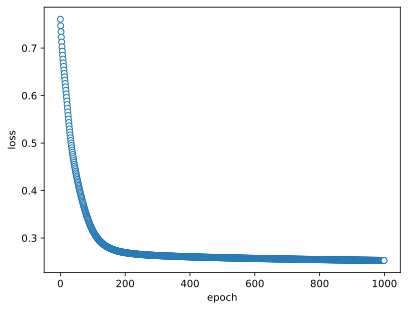

In [23]:
# let's test the code

ANNclassify, lossfun, optimizer = BuildANNclassify(0.05)
losses, predictions, totalacc = train_model()
print(f"predictions samples: \n{predictions[t.where((predictions > 0.5)==labels)[0],0][0:9].T}")
print(f"total accuracy: {totalacc}")

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

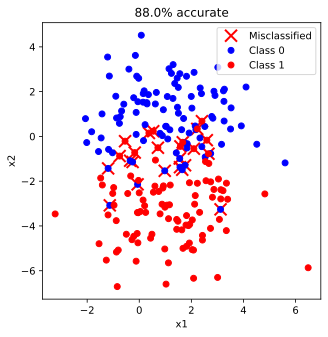

In [25]:
# view the check data

# t.where((predictions > 0).float().T != labels.T)

# find errors
misclassified = t.where(((predictions > 0.5)).detach().T != labels.T)[1]
# misclassified
# data[misclassified,0]

# plot the labeled data
fig = plt.figure(figsize=(5,5))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx' , markersize=12, markeredgewidth=2, label='Misclassified')
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bo', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title(f'{totalacc}% accurate')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

In [26]:
# let's run each iteration of learning rate over 50 rounds and take average of accuracy

learning_rates = t.linspace(0.001, 0.1, 50)
NumExps = 5

avgAccByLR = t.zeros(len(learning_rates))
avgAllLosses = t.zeros((len(learning_rates),numepochs))

for i,lr in enumerate(learning_rates):
  AccByLR = t.zeros(NumExps)
  AllLosses = t.zeros((NumExps,numepochs))
  for j in range(NumExps):
    ANNclassify, lossfun, optimizer = BuildANNclassify(lr)
    losses, predictions, totalacc = train_model()
    AccByLR[j] = totalacc
    AllLosses[j,:] = losses.detach()

  avgAccByLR[i] += AccByLR.mean()
  avgAllLosses[i,:] += AllLosses.mean(axis=0)


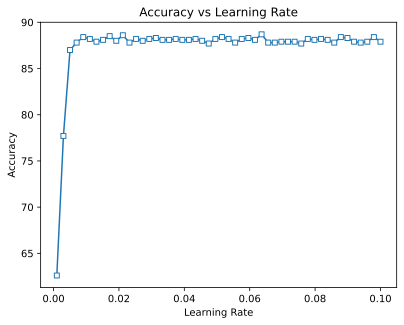

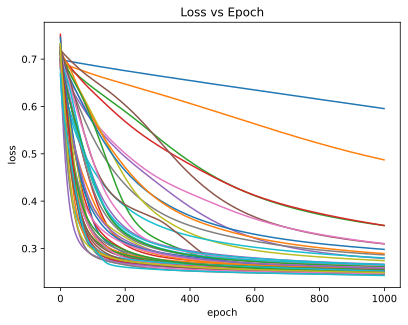

In [27]:
plt.plot(learning_rates,avgAccByLR,'s-',markerfacecolor='w',markersize=5)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

plt.plot(avgAllLosses.T)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs Epoch')
plt.show()

**Please Note:**

Simple Problems require Simple Solutions.

Querties are linearly separable. so a linear separator will out-perform a non-linear separator.

Hence, you would see that logistic regression or k-means would outperform non-linear models since complex models have a natural tendencies to find complex boundaries/solutions.

**Always look at the problem first and don't blindly throw a complex model into play**

### Multi-Output ANN (iris dataset)

In [28]:
import torch as t
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [30]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


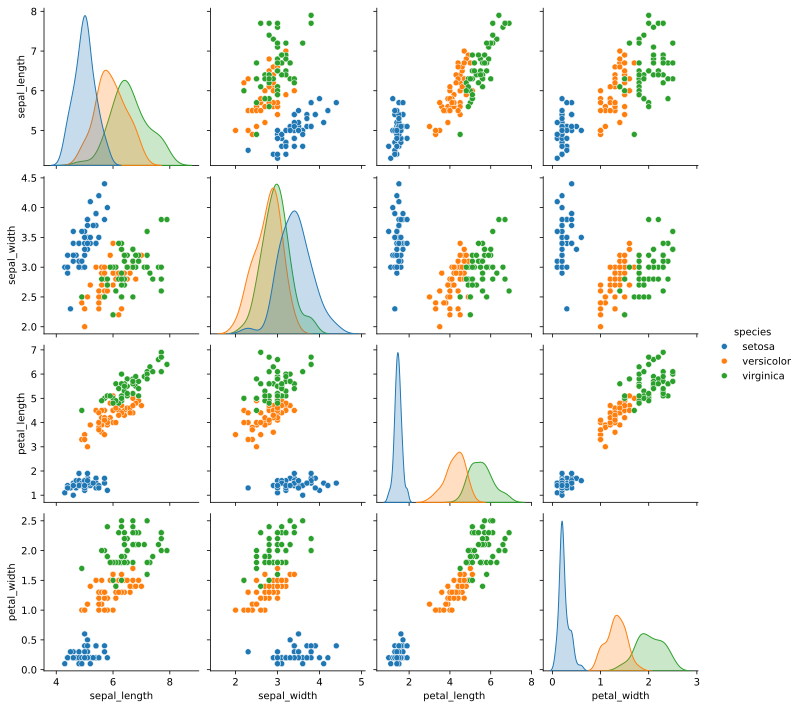

In [31]:
# some plots to show the data
sns.pairplot(iris, hue='species')
plt.show()

In [33]:
# organize the data

data = t.tensor(iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values).float()
labels = t.zeros(len(data), dtype=t.long)
labels[iris.species == 'setosa'] = 0
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

print(f"data: \n{data[0:9]}")
print(f"labels: \n{labels[0:9]}")


data: 
tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000],
        [5.4000, 3.9000, 1.7000, 0.4000],
        [4.6000, 3.4000, 1.4000, 0.3000],
        [5.0000, 3.4000, 1.5000, 0.2000],
        [4.4000, 2.9000, 1.4000, 0.2000]])
labels: 
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])


In [34]:
# create the model

def BuiltMultiANN():
  ANNmulti = nn.Sequential(
      nn.Linear(4, 64, bias=True),  # input layer
      nn.ReLU(),                   # activation layer
      nn.Linear(64, 64, bias=True),  # hidden layer
      nn.ReLU(),                   # activation layer
      nn.Linear(64, 3, bias=True),  # output layer
  )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = t.optim.SGD(ANNmulti.parameters(), lr=0.05)

  return ANNmulti, lossfun, optimizer

In [ ]:
numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ANNiris(data)

  # compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = torch.argmax(yHat,axis=1) == labels # booleans (false/true)
  matchesNumeric = matches.float()              # convert to numbers (0/1)
  accuracyPct = 100*torch.mean(matchesNumeric)  # average and x100
  ongoingAcc.append( accuracyPct )              # add to list of accuracies

# final forward pass
predictions = ANNiris(data)

predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == labels).float())

In [ ]:
# report accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

In [ ]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(sm(yHat),axis=1)

In [ ]:
# plot the raw model outputs

fig = plt.figure(figsize=(10,4))

plt.plot(sm(yHat.detach()),'s-',markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa','versicolor','virginica'])
plt.show()

# try it again without the softmax!